### Explanation
not considering trading costs!!
building a classification model that takes the prior n day asset direction 
1 if positive and -1 if negative; to predict the future dire
if the predicted direction is positive the asset will be bought or hold, and if the predicted direction is negative the asset is assumed to be shorted. 

In [1]:
!pip install yfinance
import numpy as np #get calculations library
import yfinance as yf #get financial data from internet

In [2]:
df = yf.download('AAPL',start='2020-01-01') #pulling a dataframe containing stock price for apple

[*********************100%***********************]  1 of 1 completed


In [3]:
df['returns'] = np.log(df.Close.pct_change() + 1) #calculating the log returns for apple

In [4]:
df['direction'] = [1 if i > 0 else -1 for i in df.returns] #transform returns into 1 of pos and -1 if negative

In [5]:
def lagit(df, lags): #just pulls the lag returns: returns for the previous n days
    names = []
    for i in range(1,lags + 1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        df['Lag_'+str(i)+'_dir'] = [1 if j > 0 else -1 for j in df['Lag_'+str(i)]]
        names.append('Lag_'+str(i)+'_dir')
    return names  #returning names cuz they are my features for logistic regretion

In [6]:
dirnames = lagit(df, 2)

In [7]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume,returns,direction,Lag_1,Lag_1_dir,Lag_2,Lag_2_dir
Date,,,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,74.096458,135480400,NaN,-1,NaN,-1,NaN,-1


In [8]:
df.dropna(inplace=True)

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
model = LogisticRegression()

In [12]:
model.fit(df[dirnames], df['direction']) #my independent variable is direction names:dataframe of lag1dir and lag2dir my dependent variable is direction:return pos or neg, just a column containing 1 and -1

LogisticRegression()

In [13]:
df['prediction_Logit'] = model.predict(df[dirnames])

In [15]:
df['prediction_Logit'] #values resulting out of the logistic regression model

Date
2020-01-07   -1
2020-01-08    1
2020-01-09   -1
2020-01-10   -1
2020-01-13   -1
             ..
2021-10-18   -1
2021-10-19   -1
2021-10-20   -1
2021-10-21   -1
2021-10-22   -1
Name: prediction_Logit, Length: 454, dtype: int64

In [17]:
df['strat_Logit'] = df['prediction_Logit'] * df['returns'] #multiplying the position and the returns

In [18]:
np.exp(df[['returns', 'strat_Logit']].sum())  #exp because we are working with log returns and want to change back

returns        1.983856
strat_Logit    2.667818
dtype: float64

In [19]:
# we can see the logit regression outperformed the asset, might be a case of overfitting

<AxesSubplot:xlabel='Date'>

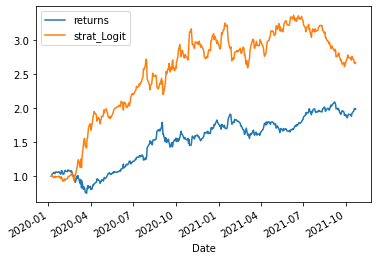

In [20]:
np.exp(df[['returns', 'strat_Logit']].cumsum()).plot()

In [21]:
#is this realistic? we can aproach using a train test split and fit the model on the training data and predict stuff on the testing data 

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.25, random_state=0)  #shuffle has to be false to avoid the dates getting messed up; we have a small sample of data around 400 entries, test size cant be much bigger

In [24]:
train = train.copy()

In [25]:
test = test.copy()

In [26]:
model = LogisticRegression()

In [27]:
model.fit(train[dirnames], train['direction']) #fittting the model on the training dataset

LogisticRegression()

In [28]:
test['prediction_Logit'] = model.predict(test[dirnames])

In [29]:
test['strat_Logit'] = test['prediction_Logit'] * test['returns']

In [30]:
np.exp(test[['returns', 'strat_Logit']].sum())

returns        1.211127
strat_Logit    0.850867
dtype: float64

In [31]:
#now we can see that the strategy is underperforming the asset return, at least when we take a train test split like we choose. lets see a visualization

<AxesSubplot:xlabel='Date'>

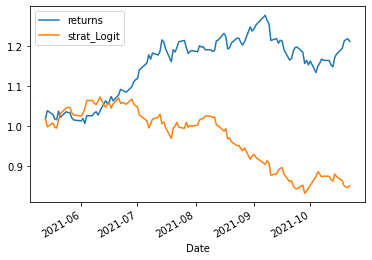

In [33]:
np.exp(test[['returns', 'strat_Logit']].cumsum()).plot()

In [34]:
# we can see the asset is outperforming the strategy. lets create a confusion matrix

In [35]:
from sklearn import metrics

In [36]:
metrics.confusion_matrix(test['direction'], test['prediction_Logit'])

array([[27, 24],
       [36, 27]], dtype=int64)

In [37]:
# we can see that in 27 cases we have a -1 prediction and we have a -1 direction
#and 27 cases where we predict false values
#we can use a classification report

In [38]:
print(metrics.classification_report(test['direction'], test['prediction_Logit']))

              precision    recall  f1-score   support

          -1       0.43      0.53      0.47        51
           1       0.53      0.43      0.47        63

    accuracy                           0.47       114
   macro avg       0.48      0.48      0.47       114
weighted avg       0.48      0.47      0.47       114



In [39]:
# we see a 53% precision when looking at predicted 1 and only a 43% when predicting a -1. 
# more wrong predictions on -1 than right predictions on -1, and more wrong predictions on -1 than wrong predictions on 1

In [ ]:
# we can play a bit with lags we might have different results but probably will not outperfomrm the asset. 
# we can change the asset string and see what we get for returns for a different asset.